# Data Analysis

Comprehensive Data Cleaning & Exploratory Analysis of Job Market Trends

Caroline O’Sullivan (Boston University)  
Bhargavi Manyala (Boston University)  
Taylor Luckenbill (Boston University)

# Import Data

Importing dataset using Pyspark..The code shows the schema and few rows
of the dataset.

In [1]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

    
# Load the CSV file into a Spark DataFrame
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("lightcast_job_postings.csv")

df.createOrReplaceTempView("jobs")


# Show schema
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/23 19:17:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/23 19:17:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
[Stage 0:>                                                          (0 + 1) / 1]                                                                                [Stage 1:>                                                          (0 + 1) / 1]                                                                                

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

25/09/23 19:17:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.

[Stage 2:>                                                          (0 + 1) / 1][Stage 2:===========================================================(1 + 0) / 1]                                                                                

+----------------------------------------+-----------------+-----------------------+----------+--------+---------+--------+----------------------+---------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-------------------+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data Cleaning & Preprocessing

## Drop Unnecessary Columns

### Redundant Columns

-   Drop: NAICS2, NAICS2_NAME, NAICS3, NAICS3_NAME, NAICS4, NAICS4_NAME,
    NAICS5, NAICS5_NAME, NAICS6, NAICS6_NAME
-   Retain: NAICS_2022_2, NAICS_2022_2_NAME through NAICS_2022_6,
    NAICS_2022_6_NAME
-   Drop: SOC_2, SOC_2_NAME, SOC_3, SOC_3_NAME, SOC_4, SOC_4_NAME,
    SOC_5, SOC_5_NAME
-   Retain: SOC_2021_2, SOC_2021_2_NAME, SOC_2021_3, SOC_2021_3_NAME,
    SOC_2021_4, SOC_2021_4_NAME, SOC_2021_5, SOC_2021_5_NAME
-   Drop: CITY, COUNTY, STATE, REMOTE_TYPE, EMPLOYMENT_TYPE (numeric
    codes when text names exist)
-   Drop : COUNTY_OUTGOING, COUNTY_NAME_OUTGOING, COUNTY_INCOMING,
    COUNTY_NAME_INCOMING, MSA_OUTGOING, MSA_NAME_OUTGOING, MSA_INCOMING,
    MSA_NAME_INCOMING (geographic mobility data)
-   Retain: LOCATION, CITY_NAME, COUNTY_NAME, STATE_NAME, MSA, MSA_NAME,
    REMOTE_TYPE_NAME, EMPLOYMENT_TYPE_NAME (text-based fields)
-   Drop: TITLE_RAW, TITLE, TITLE_NAME, COMPANY_RAW (unprocessed
    versions)
-   Retain: TITLE_CLEAN, COMPANY_NAME (cleaned/processed versions)
-   Drop: EDUCATION_LEVELS, MIN_EDULEVELS, MAX_EDULEVELS (numeric codes)
-   Retain : EDUCATION_LEVELS_NAME, MIN_EDULEVELS_NAME,
    MAX_EDULEVELS_NAME (descriptive names)
-   Drop: LOT_V6_SPECIALIZED_OCCUPATION,
    LOT_V6_SPECIALIZED_OCCUPATION_NAME, LOT_V6_OCCUPATION,
    LOT_V6_OCCUPATION_NAME, LOT_V6_OCCUPATION_GROUP,
    LOT_V6_OCCUPATION_GROUP_NAME, LOT_V6_CAREER_AREA,
    LOT_V6_CAREER_AREA_NAME (version-specific)
-   Retain: LOT_CAREER_AREA, LOT_CAREER_AREA_NAME, LOT_OCCUPATION,
    LOT_OCCUPATION_NAME, LOT_SPECIALIZED_OCCUPATION,
    LOT_SPECIALIZED_OCCUPATION_NAME, LOT_OCCUPATION_GROUP,
    LOT_OCCUPATION_GROUP_NAME (current standard)

### Irrelevant Columns

-   Drop: LAST_UPDATED_DATE, LAST_UPDATED_TIMESTAMP, DUPLICATES,
    SOURCE_TYPES, SOURCES, ACTIVE_URLS, ACTIVE_SOURCES_INFO (system
    tracking only)
-   Retain: Core job posting fields only
-   Drop: ID, URL, BODY (technical identifier, link, and full text not
    needed for analysis)
-   Retain: Main job details (title, company, salary, location)
-   Drop: CIP6, CIP6_NAME, CIP4, CIP4_NAME, CIP2, CIP2_NAME (education
    codes) ONET, ONET_NAME, ONET_2019, ONET_2019_NAME (extra occupation
    codes) LIGHTCAST_SECTORS, LIGHTCAST_SECTORS_NAME, (alternative
    grouping)
-   Retain: Standard NAICS, SOC, and LOT classifications only
-   Drop: SKILLS, SKILLS_NAME, SPECIALIZED_SKILLS,
    CERTIFICATIONS,COMMON_SKILLS,SOFTWARE_SKILLS
-   Retain:
    SPECIALIZED_SKILLS_NAME,CERTIFICATIONS_NAME,COMMON_SKILLS_NAME,SOFTWARE_SKILLS_NAME
-   Drop: MODELED_EXPIRED, MODELED_DURATION (estimates, not real values)
-   Retain: POSTED, EXPIRED, DURATION (actual posting data)

### Why are we removing multiple versions of NAICS/SOC codes?

The dataset includes both older and newer versions of industry (NAICS)
and occupation (SOC) codes. Keeping multiple versions creates
duplication and confusion because the same job could be categorized
under two systems. To avoid this, we retain only the most recent
standards — NAICS 2022 and SOC 2021 — which reflect the current labor
market.

### How will this improve analysis?

-   Improves analysis as follows:
-   Ensures clarity by eliminating overlapping or outdated categories.
-   Maintains consistency so all jobs follow the same classification.
-   Improves efficiency by reducing extra columns that don’t add value.
-   Increases accuracy since results are based on the most up-to-date
    classification systems.

### Dropping Unnecessary Columns(Python Implementation)

In [3]:
columns_to_drop = [
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME",
    "NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME",
    "NAICS6", "NAICS6_NAME","ID","URL","BODY",
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME",
    "SOC_4", "SOC_4_NAME", "SOC_5", "SOC_5_NAME",
    "CITY", "COUNTY", "STATE", "REMOTE_TYPE", "EMPLOYMENT_TYPE",
    "COUNTY_OUTGOING", "COUNTY_NAME_OUTGOING",
    "COUNTY_INCOMING", "COUNTY_NAME_INCOMING",
    "MSA_OUTGOING", "MSA_NAME_OUTGOING",
    "MSA_INCOMING", "MSA_NAME_INCOMING",
    "TITLE_RAW", "TITLE", "TITLE_NAME", "COMPANY_RAW",
    "EDUCATION_LEVELS", "MIN_EDULEVELS", "MAX_EDULEVELS",
    "LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_SPECIALIZED_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION", "LOT_V6_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION_GROUP", "LOT_V6_OCCUPATION_GROUP_NAME",
    "LOT_V6_CAREER_AREA", "LOT_V6_CAREER_AREA_NAME",
    "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP",
    "DUPLICATES", "SOURCE_TYPES", "SOURCES",
    "ACTIVE_URLS", "ACTIVE_SOURCES_INFO",
    "CIP2", "CIP2_NAME", "CIP4", "CIP4_NAME", "CIP6", "CIP6_NAME",
    "ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME",
    "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME",
    "SKILLS", "SKILLS_NAME", "SPECIALIZED_SKILLS",
    "CERTIFICATIONS","COMMON_SKILLS", "SOFTWARE_SKILLS", 
    "MODELED_EXPIRED", "MODELED_DURATION"
]

df = df.drop(*columns_to_drop)
df.show(truncate=False)
df.count()

+--------+---------+--------+---------+-----------------------------------+-------------------+---------------------------------------------------------------------------+-------------------+------------------+----------------------+--------------------+--------------------+-------------+------+----------------+-------------------+---------+-----------+-------------------------------------------------+------------------+--------------------+-----+-------------------------------------+-------------+-------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[Stage 4:>                                                          (0 + 1) / 1]                                                                                

72498

## Handling Missing Values(Numerical Python Implementation)

[Stage 7:>                                                          (0 + 1) / 1]                                                                                

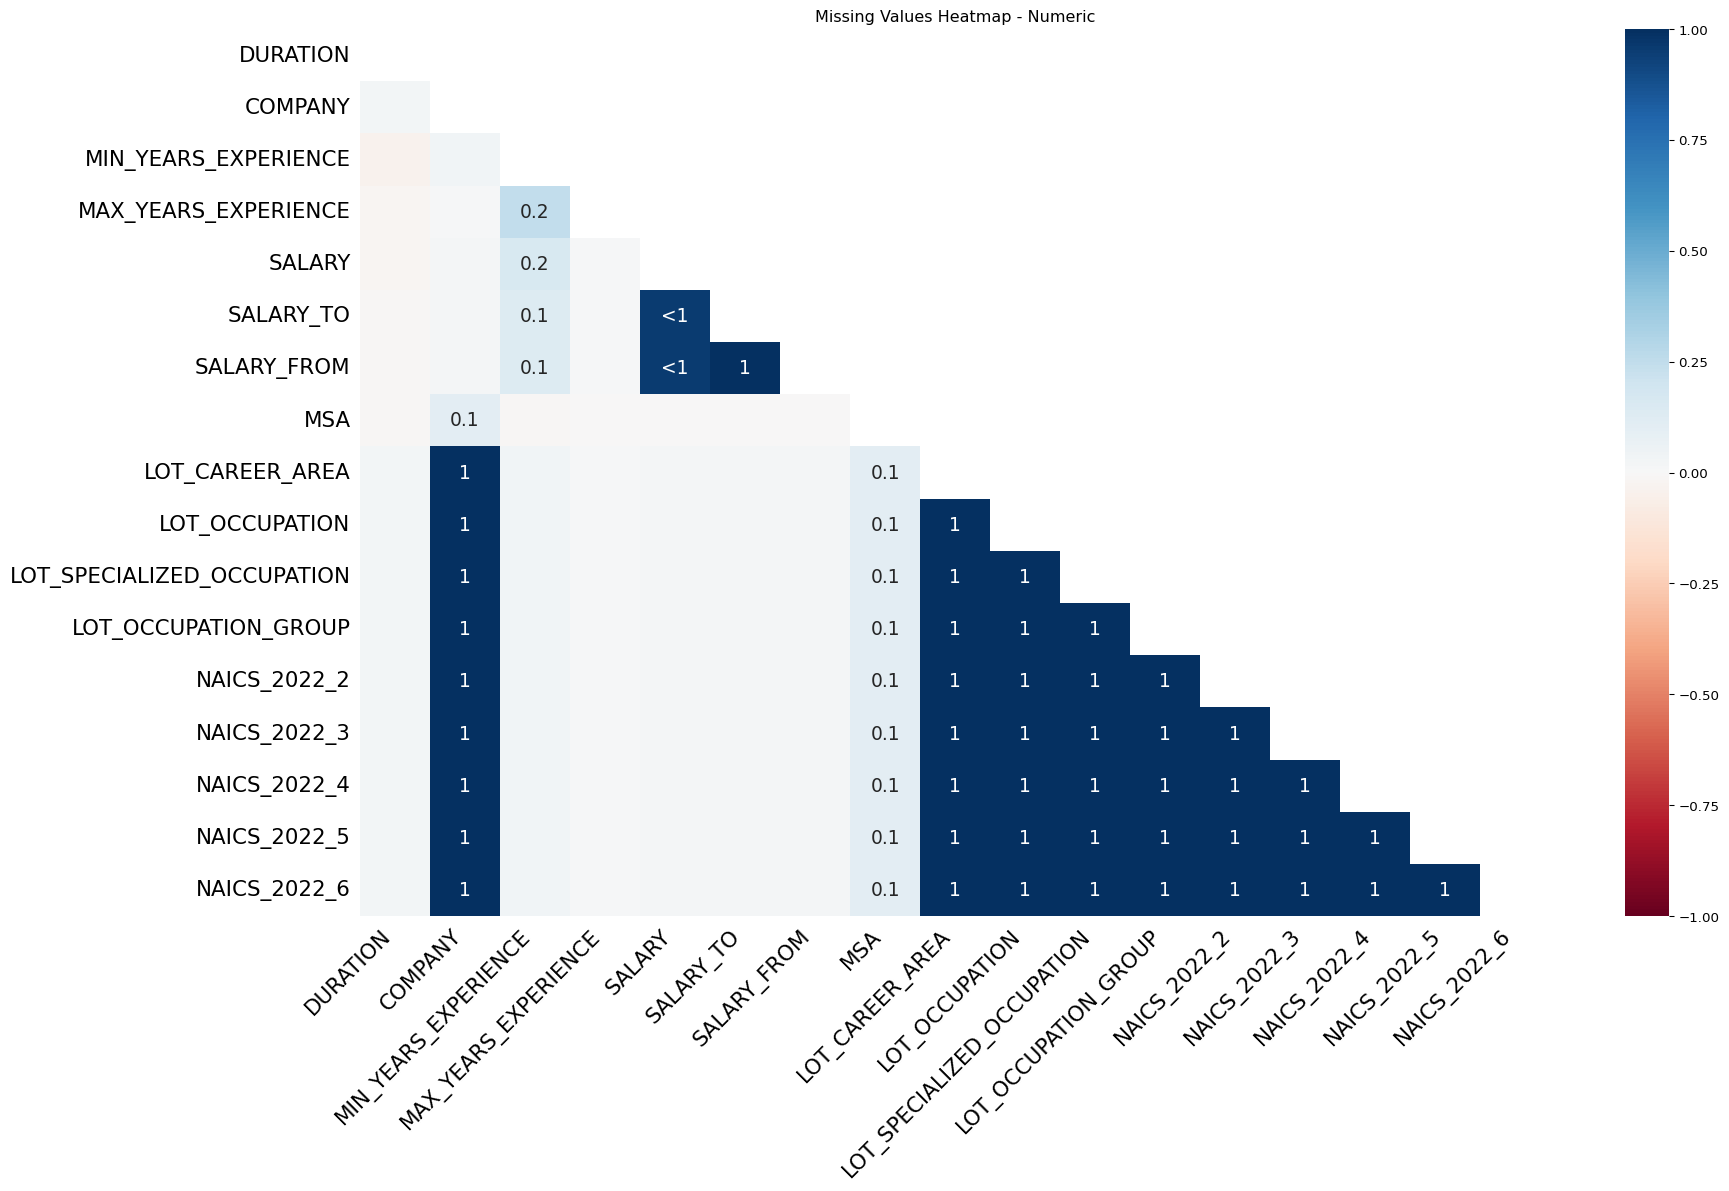

In [4]:
import missingno as msno
import matplotlib.pyplot as plt

numeric_cols = [
    "DURATION", "COMPANY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "SALARY", "SALARY_TO", "SALARY_FROM", "MSA",
    "LOT_CAREER_AREA", "LOT_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION",
    "LOT_OCCUPATION_GROUP", "NAICS_2022_2", "NAICS_2022_3",
    "NAICS_2022_4", "NAICS_2022_5", "NAICS_2022_6"
]

pandas_num = df.select(numeric_cols).toPandas()

msno.heatmap(pandas_num)
plt.title("Missing Values Heatmap - Numeric")
plt.show()

pandas_num[numeric_cols] = pandas_num[numeric_cols].fillna(
    pandas_num[numeric_cols].median(numeric_only=True)
)
pandas_num.head()

## Handling Missing Values(Categorical Python Implementation)

[Stage 8:>                                                          (0 + 1) / 1]                                                                                

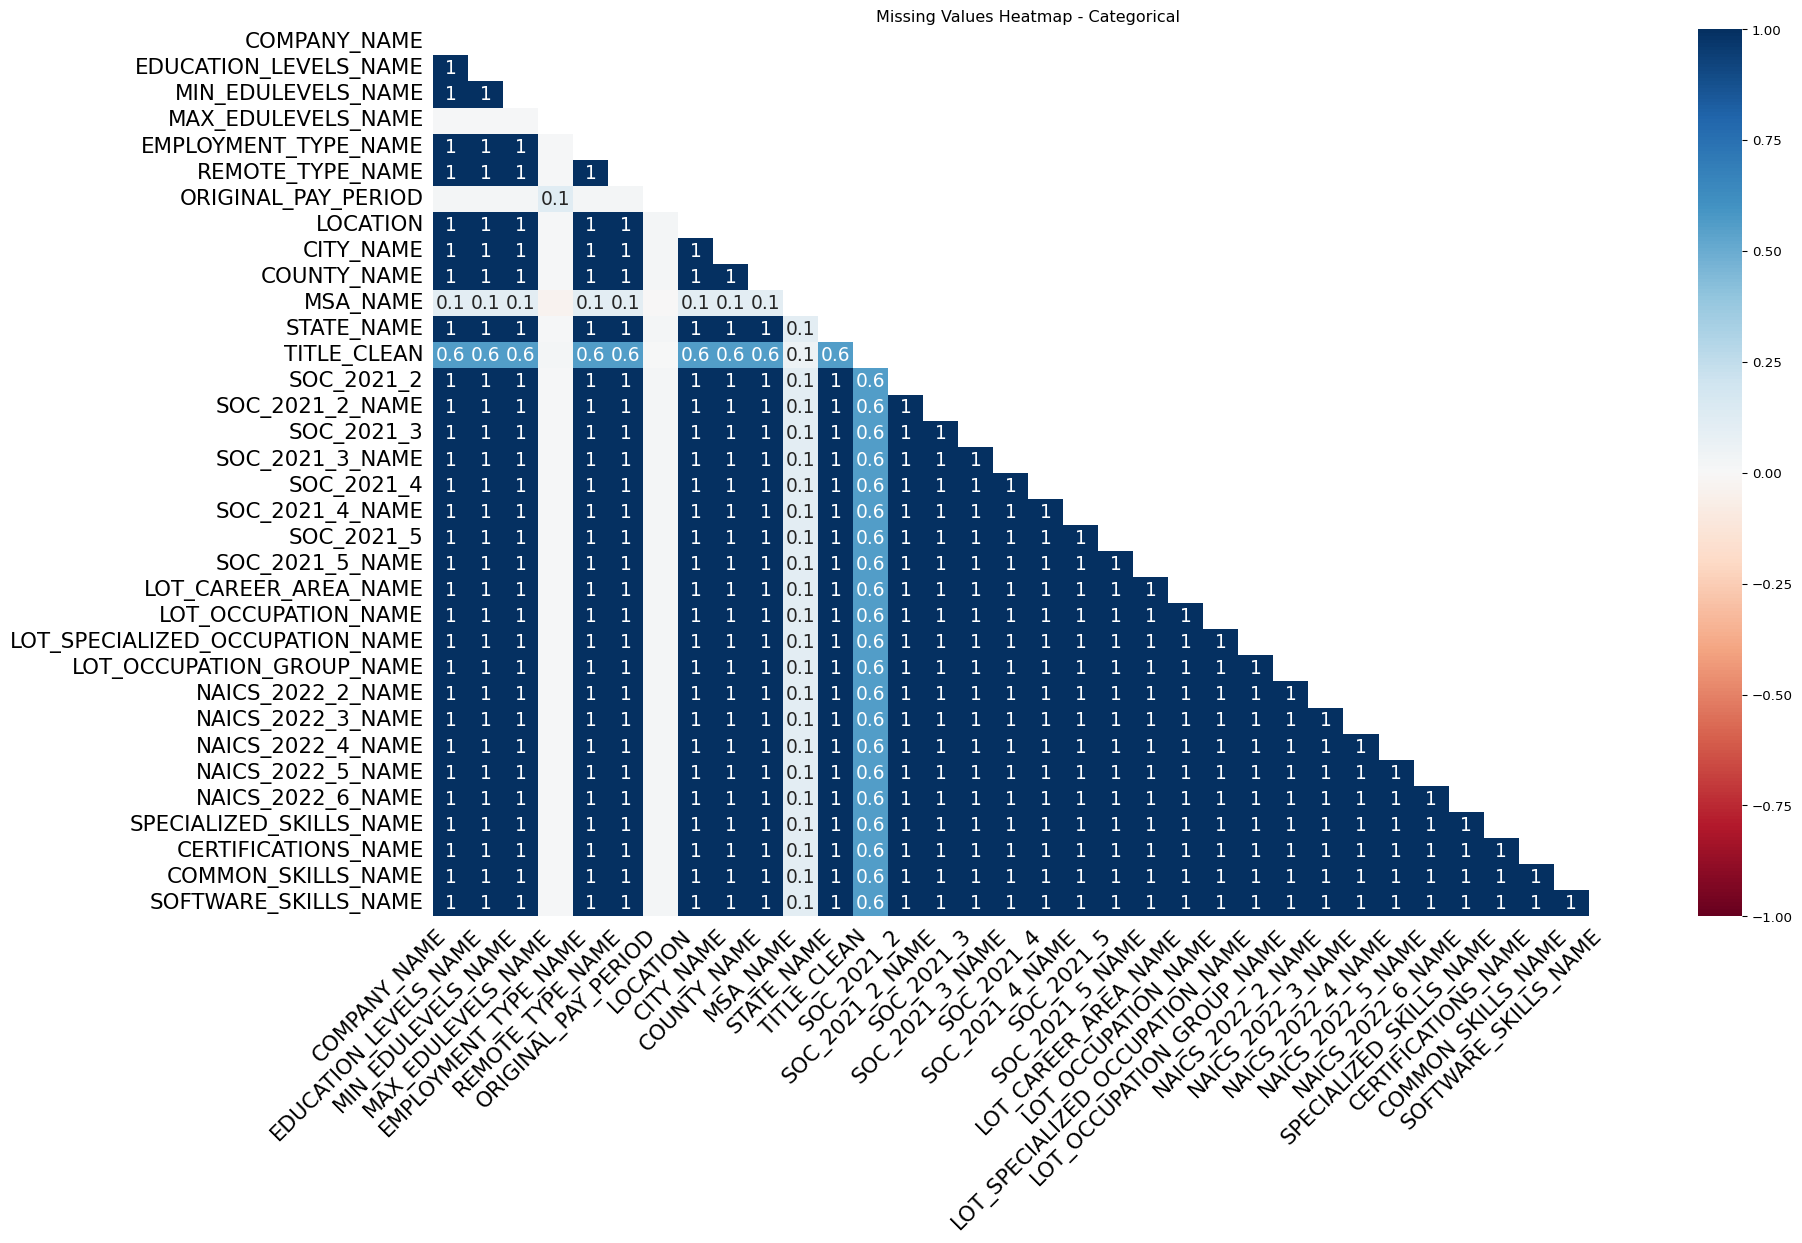

5 rows × 34 columns

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

categorical_cols = [
    "COMPANY_NAME", "EDUCATION_LEVELS_NAME",
    "MIN_EDULEVELS_NAME", "MAX_EDULEVELS_NAME", "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME", "ORIGINAL_PAY_PERIOD", "LOCATION", "CITY_NAME",
    "COUNTY_NAME", "MSA_NAME", "STATE_NAME", "TITLE_CLEAN",
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "SOC_2021_5_NAME",
    "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION_NAME",
    "LOT_SPECIALIZED_OCCUPATION_NAME", "LOT_OCCUPATION_GROUP_NAME",
    "NAICS_2022_2_NAME", "NAICS_2022_3_NAME", "NAICS_2022_4_NAME",
    "NAICS_2022_5_NAME", "NAICS_2022_6_NAME","SPECIALIZED_SKILLS_NAME","CERTIFICATIONS_NAME","COMMON_SKILLS_NAME","SOFTWARE_SKILLS_NAME"
]

pandas_cat = df.select(categorical_cols).toPandas()

msno.heatmap(pandas_cat)
plt.title("Missing Values Heatmap - Categorical")
plt.show()

pandas_cat[categorical_cols] = pandas_cat[categorical_cols].fillna("Unknown")

pandas_cat.head()

## Handling Missing Values(Date Python Implementation)

[Stage 9:>                                                          (0 + 1) / 1]                                                                                

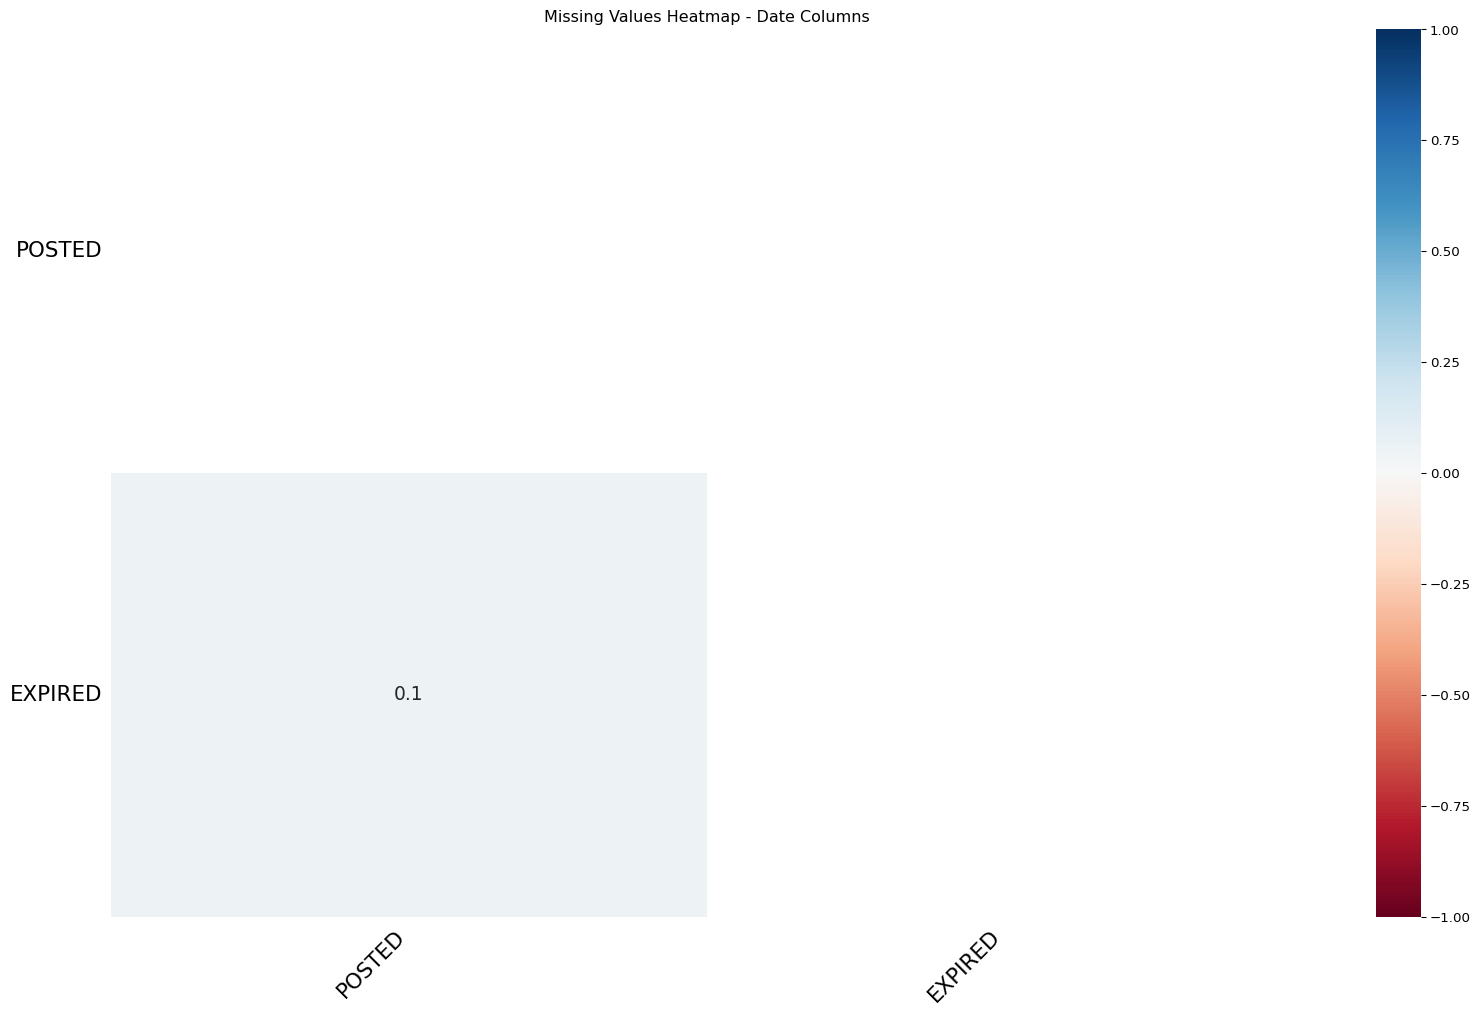

In [6]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

date_cols = ["POSTED", "EXPIRED"]
pandas_date = df.select(date_cols).toPandas()

msno.heatmap(pandas_date)
plt.title("Missing Values Heatmap - Date Columns")
plt.show()

for col in date_cols:
    pandas_date[col] = pd.to_datetime(pandas_date[col], errors="coerce")
    pandas_date[col] = pandas_date[col].fillna(pandas_date[col].mode()[0])

pandas_date.head()

## Handling Missing Values(Combined Dataframe Python Implementation)

In [7]:
import pandas as pd

pandas_handled_missing_values = pd.concat([pandas_num, pandas_cat, pandas_date], axis=1)

pandas_handled_missing_values.head()

5 rows × 53 columns

## Duplicates Removal(Python Implementation)

In [8]:
pandas_cleaned = pandas_handled_missing_values.drop_duplicates(
    subset=["TITLE_CLEAN", "COMPANY_NAME", "LOCATION","POSTED"],
    keep="first"
)

pandas_cleaned

70789 rows × 53 columns

## Data Analysis

In [9]:
# import programs for plotting visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Science and technical services more than double the next job posting group by industry.

/tmp/ipykernel_6809/706560984.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



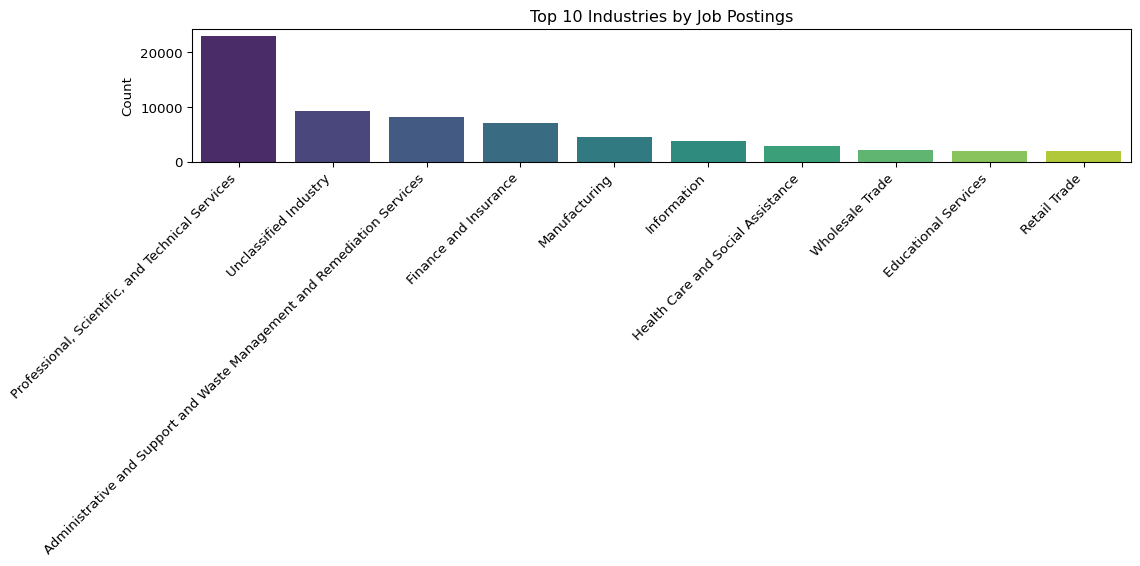

In [10]:
# Count occurrences
industry_counts = pandas_cleaned["NAICS_2022_2_NAME"].value_counts().reset_index()
industry_counts.columns = ["Industry", "Count"]

# Optional: limit to top 10 for readability
top10 = industry_counts.head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10,
    x="Industry",
    y="Count",
    palette="viridis"  # or "magma", "coolwarm", etc.
)

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Industries by Job Postings")
plt.xlabel(None)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [11]:
# Restrict to top 10 industries
top10 = pandas_cleaned["NAICS_2022_2_NAME"].value_counts().index[:10]
filtered = pandas_cleaned[pandas_cleaned["NAICS_2022_2_NAME"].isin(top10)]

print(filtered.columns)

Index(['DURATION', 'COMPANY', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE',
       'SALARY', 'SALARY_TO', 'SALARY_FROM', 'MSA', 'LOT_CAREER_AREA',
       'LOT_OCCUPATION', 'LOT_SPECIALIZED_OCCUPATION', 'LOT_OCCUPATION_GROUP',
       'NAICS_2022_2', 'NAICS_2022_3', 'NAICS_2022_4', 'NAICS_2022_5',
       'NAICS_2022_6', 'COMPANY_NAME', 'EDUCATION_LEVELS_NAME',
       'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE_NAME',
       'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'LOCATION', 'CITY_NAME',
       'COUNTY_NAME', 'MSA_NAME', 'STATE_NAME', 'TITLE_CLEAN', 'SOC_2021_2',
       'SOC_2021_2_NAME', 'SOC_2021_3', 'SOC_2021_3_NAME', 'SOC_2021_4',
       'SOC_2021_4_NAME', 'SOC_2021_5', 'SOC_2021_5_NAME',
       'LOT_CAREER_AREA_NAME', 'LOT_OCCUPATION_NAME',
       'LOT_SPECIALIZED_OCCUPATION_NAME', 'LOT_OCCUPATION_GROUP_NAME',
       'NAICS_2022_2_NAME', 'NAICS_2022_3_NAME', 'NAICS_2022_4_NAME',
       'NAICS_2022_5_NAME', 'NAICS_2022_6_NAME', 'SPECIALIZED_SKILLS_NAME',
       

# Information, Educational Services, and Healthcare and Social Assistance have the most variation in Salary. The rest of the industries a reletively thightly grouped on salary when group by Industry.

/tmp/ipykernel_6809/776592341.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



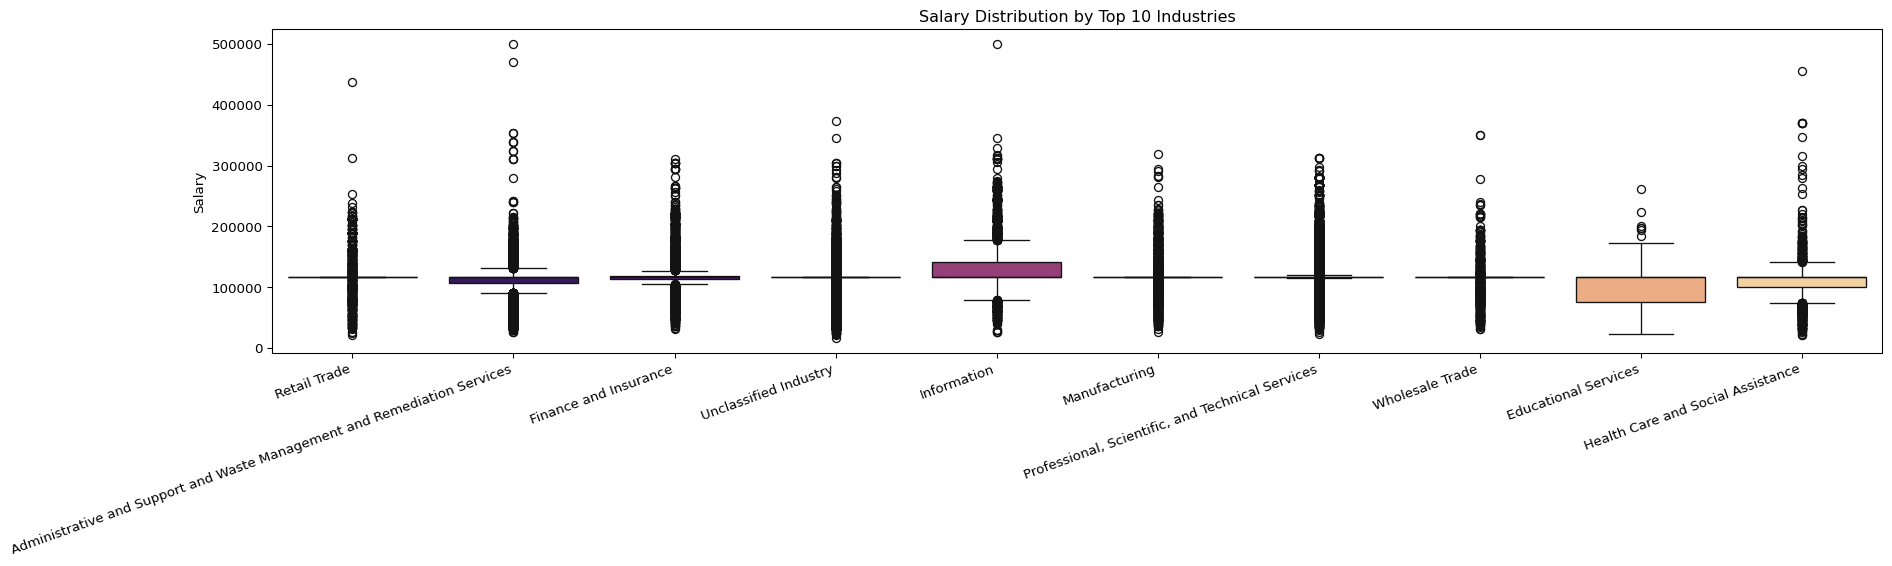

In [12]:
# Plot
plt.figure(figsize=(20,6))
sns.boxplot(
    data=filtered,
    x="NAICS_2022_2_NAME",
    y="SALARY",
    palette="magma"
)

plt.xticks(rotation=20, ha="right")
plt.title("Salary Distribution by Top 10 Industries")
plt.xlabel(None)
plt.ylabel("Salary")  
plt.tight_layout()
plt.show()


# Professional, Scientific, and Technical Services is by far the largest employer industry.

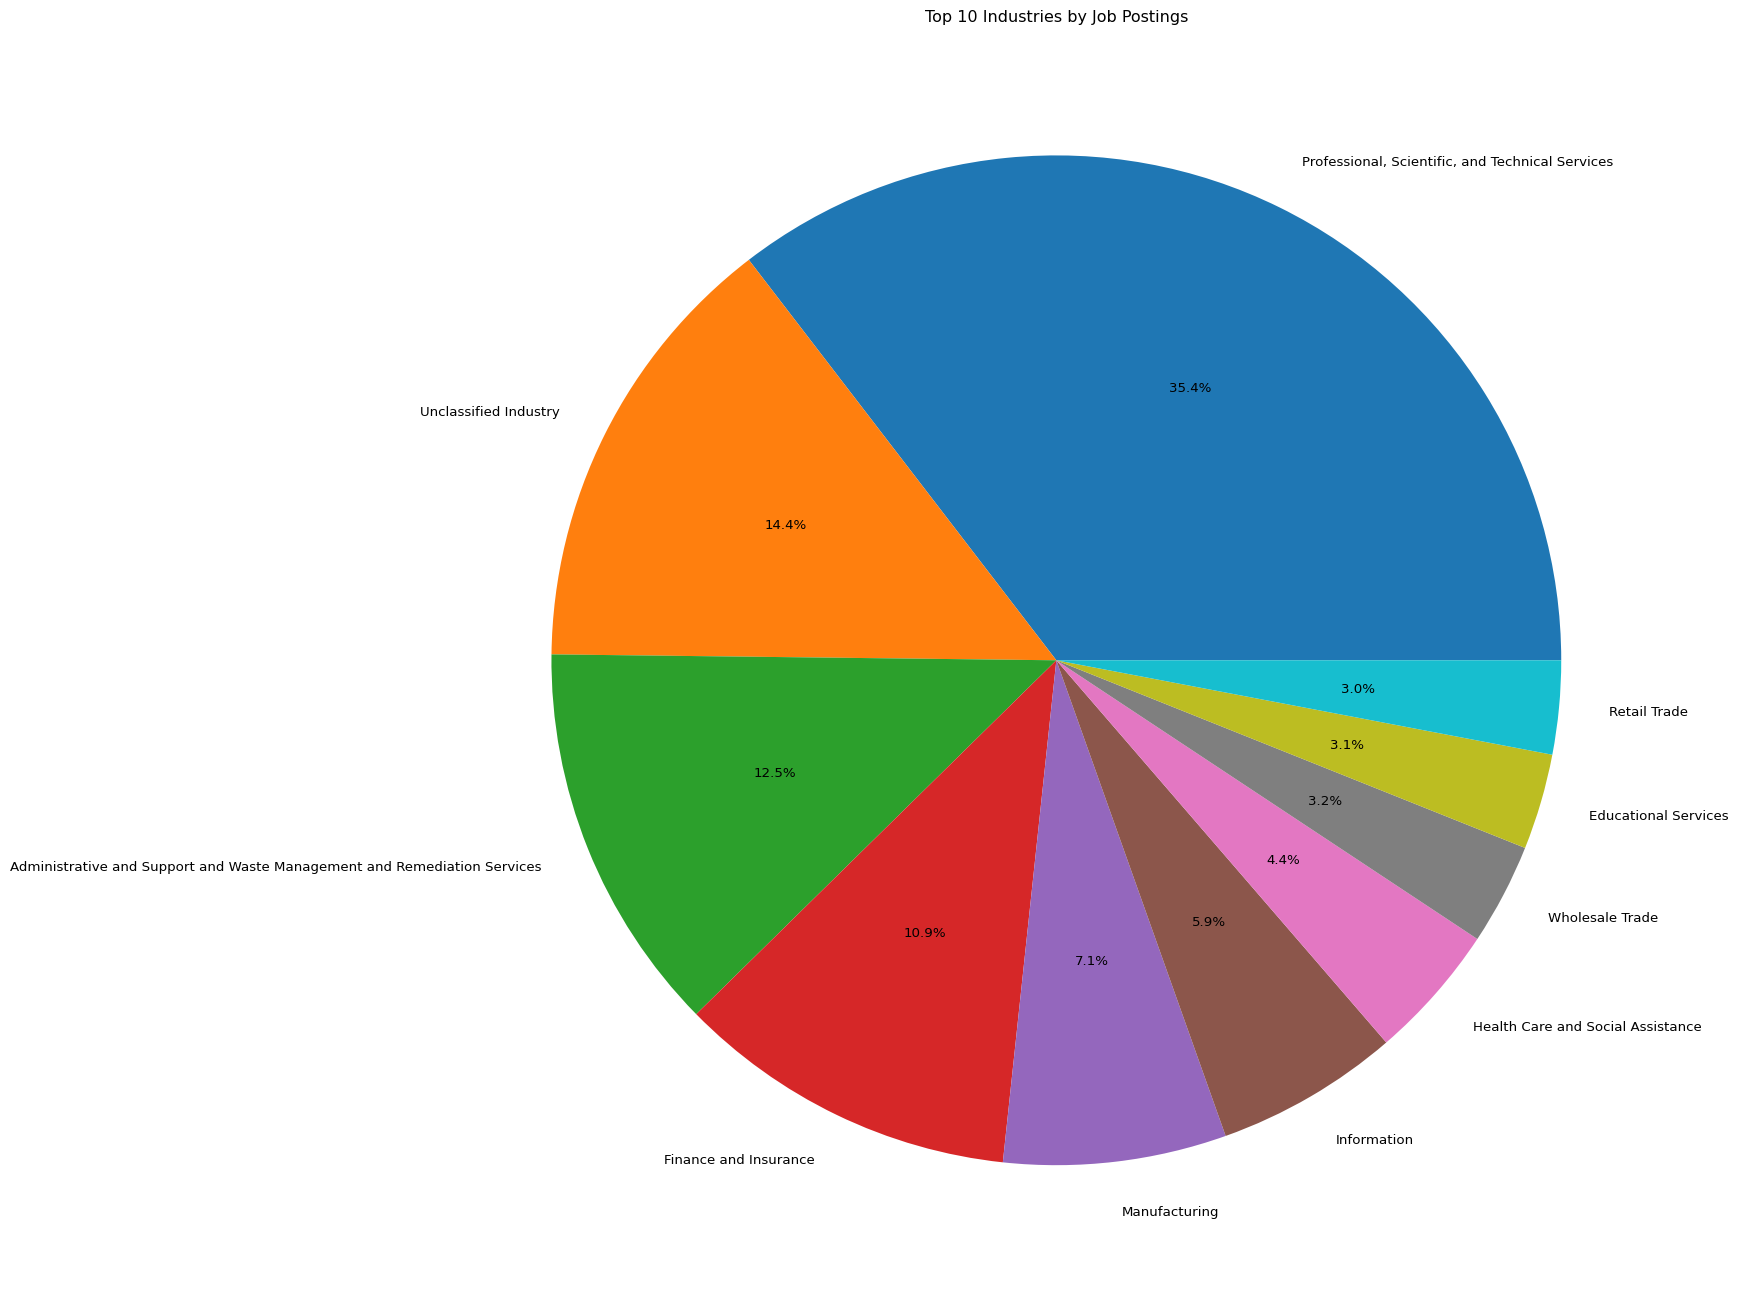

In [13]:
# Count occurrences
industry_counts = pandas_cleaned["NAICS_2022_2_NAME"].value_counts()

# take top 10 industries for readability
top10 = industry_counts.head(10)

# Pie chart
plt.figure(figsize=(18,18))
plt.pie(
    top10.values,           # sizes
    labels=top10.index,     # labels
    autopct='%1.1f%%',      # show percentages
)
plt.title("Top 10 Industries by Job Postings")
plt.tight_layout()
plt.show()